# Linear Regression
Linear regression models are a good starting point for regression tasks. It's simple, fast and interpretable. We will first start by fitting line to randomly generated data, followed by using dataset we collected from XXX to do a more comprehensive walkthrough.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression
$y = ax + b$ is the most familiar form of linear regression, where $a$ is the slope and $b$ is known as the intercept. 

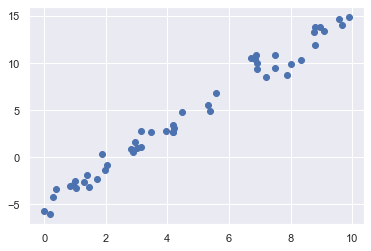

In [2]:
# set random state
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

In [3]:
from sklearn.linear_model import LinearRegression
# initiate a LinearRegression object
model = LinearRegression()

In [4]:
# reshape x from 1D (50, ) to 2D array (50, 1)
model.fit(x[:, np.newaxis], y)

LinearRegression()

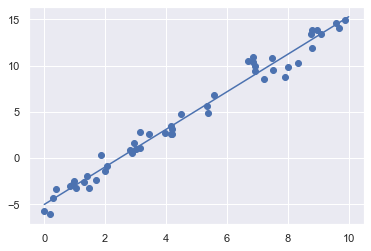

In [5]:
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit);

In [6]:
print("Model slope:       ", model.coef_[0])
print("Model intercept:   ", model.intercept_)

Model slope:        2.0272088103606953
Model intercept:    -4.998577085553204


The *LinearRegression* Class can also be used to fit multidimensional linear models in the form below:

$y = a_0 + a_1x_1 + a_2x_2 + ...$

where there are multiple $x$ values or features. Geometrically, this is akin to fitting a plane to
points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

In [7]:
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

In [8]:
model.fit(X, y)
print(model.coef_)
print(model.intercept_)

[ 1.5 -2.   1. ]
0.49999999999999556


## Basis Function Regression
To adapt linear regression to nonlinear relatiionships between variables, we need to transform the data according to *[basis functions](https://en.wikipedia.org/wiki/Basis_function#:~:text=In%20mathematics%2C%20a%20basis%20function,linear%20combination%20of%20basis%20vectors.)*.

Linearity refers to the fact that coefficients never multiply or divide each other. What we have effectively done is taken the one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$. 

### Polynomial Basis Functions

In [9]:
from sklearn.preprocessing import PolynomialFeatures

In [10]:
x = np.array([2, 3, 4])
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(x[:, np.newaxis])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [11]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(degree=7),
                           LinearRegression())

In [12]:
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
poly_model.fit(x[:, np.newaxis], y)

yfit = poly_model.predict(xfit[:, np.newaxis])

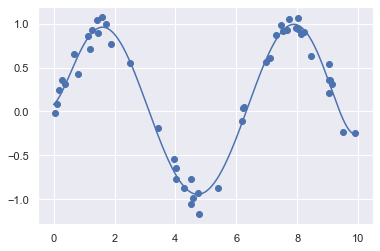

In [13]:
plt.scatter(x, y)
plt.plot(xfit, yfit);

### Gaussian Basis Function

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(np.power(arg, 2), axis))

    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self

    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,self.width_, axis=1)

In [15]:
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())

In [16]:
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

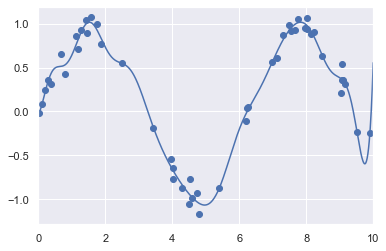

In [17]:
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

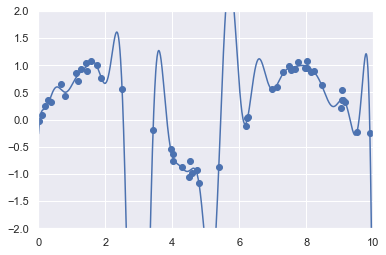

In [18]:
# However, if we use 30-dimensional basis, the model would be overfitting
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())

model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-2, 2);

In [19]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))

    if title:
        ax[0].set_title(title)
        
    ax[1].plot(model.steps[0][1].centers_,model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location', ylabel='coefficient', xlim=(0, 10))

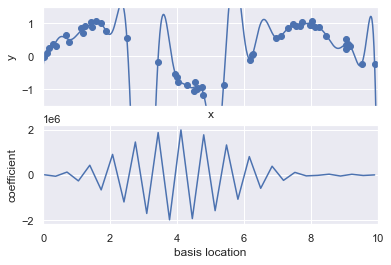

In [20]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

## Regularisation
[Regularisation](https://towardsdatascience.com/regularization-an-important-concept-in-machine-learning-5891628907ea#:~:text=Regularization%20is%20a%20technique%20used,don't%20take%20extreme%20values.) is a technique used for tuning the function by adding an additional penalty term in the error function.

### Ridge Regression (L2)
According to sklearn documentation, it is trying to minimise this loss function `||y - Xw||^2_2 + alpha * ||w||^2_2`.

This model solves a regression model where the loss function is the linear least squares function and regularisation is given by the l2-norm.

The $\alpha$ parameter controls the complexity of the resulting model. In the limit $\alpha$ -> 0, we recover the standard linear regression results; in the limit $\alpha$ -> $\infty$, all model responses will be supresssed. One advantage of rdige regression is that it can be computed very efficiently.

More details [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

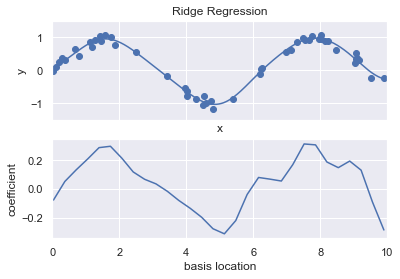

In [21]:
from sklearn.linear_model import Ridge 

# alpha is the regularisation strength 
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title="Ridge Regression")

### Lasso Regression (L1)
Lasso involves penalizing the sum of absolute values (1-norms) of regression coefficients. Due to geometric reasons lasso regression tends to favor sparse models where possible; that is, it preferentially sets model coefficients to exactly zero.

The loss optimisation function is: `(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1`

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions. As with ridge regularisation, the $\alpha$ parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation.

More details [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso).

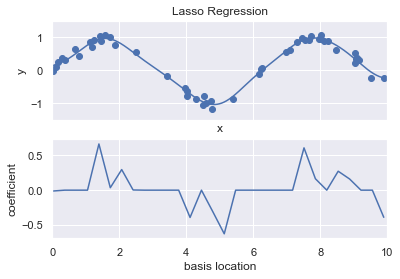

In [22]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title="Lasso Regression")